In [12]:
import pandas as pd

column_names = ['Image', 'Attention']

df1 = pd.read_csv('attention.csv', header=None, names=column_names)
df2 = pd.read_csv('./featurebycolor/color_stats.csv')
df3 = pd.read_csv('./featurebycolor/contrast_features.csv')
df4 = pd.read_csv('./featurebyshape/shape_features.csv')

In [13]:
import os

df1.rename(columns={'Image': 'image_name'}, inplace=True)
df1['image_name'] = df1['image_name'].apply(lambda x: int(os.path.splitext(x.split('/')[-1])[0]))
df4['image_name'] = df4['image_name'].apply(lambda x: int(os.path.splitext(x.split('/')[-1])[0]))


In [14]:
# Menggabungkan df1 dan df2
merged_df = pd.merge(df1, df2, on='image_name', how='inner')

# Menggabungkan hasilnya dengan df3
merged_df = pd.merge(merged_df, df3, on='image_name', how='inner')

# Menggabungkan hasilnya dengan df4
merged_df = pd.merge(merged_df, df4, on='image_name', how='inner')


In [4]:
merged_df = merged_df.dropna()
merged_df.isnull().sum()

image_name                     0
Attention                      0
mean_r                         0
mean_g                         0
mean_b                         0
std_r                          0
std_g                          0
std_b                          0
mean_h                         0
mean_s                         0
mean_v                         0
std_h                          0
std_s                          0
std_v                          0
mean_luminance                 0
mean_saturation                0
luminance_std                  0
contrast_text_vs_background    0
bright_dark_ratio              0
word_count                     0
line_count                     0
char_count                     0
text_area_ratio                0
dominant_text_position         0
avg_text_width                 0
avg_text_height                0
font_width_std                 0
font_height_std                0
font_variety_estimation        0
flesch_score                   0
readabilit

In [5]:
import ast

def expand_list_column(df, list_column):
    # Konversi string menjadi list
    df[list_column] = df[list_column].apply(ast.literal_eval)
    
    # Pisahkan list menjadi kolom terpisah dan tambahkan ke dataframe
    for i in range(8):  # Asumsi list panjangnya 8
        df[f'{list_column}_col_{i+1}'] = df[list_column].apply(lambda x: x[i] if len(x) > i else None)

    # Hapus kolom asli jika tidak diperlukan
    df = df.drop(columns=[list_column])
    
    return df

# Terapkan fungsi
merged_df = expand_list_column(merged_df, 'edge_orientation_histogram')
merged_df = merged_df.drop(columns=['image_name'])

# Tampilkan dataframe hasilnya
print(merged_df.head())


   Attention      mean_r      mean_g      mean_b      std_r      std_g  \
0          1  148.948161  142.800087  169.957003  75.601142  78.320699   
1          2  145.352230  129.316704  135.417328  55.157401  49.500892   
2          1  147.211737  141.022195  166.035403  68.148730  70.589171   
3          4   45.376553   35.869680   39.970896  82.331267  73.712899   
4          1  115.142762  125.256714  119.305369  69.447026  55.492169   

       std_b      mean_h      mean_s      mean_v  ...  balance_top_bottom  \
0  66.902932   93.913914   49.821437  170.235442  ...               0.964   
1  25.341361   99.509070   93.510393  168.963624  ...               1.000   
2  57.624317  113.326934   52.279412  167.987337  ...               0.953   
3  75.087450   70.051890   75.402194   46.348216  ...               0.958   
4  50.737138   86.369864  124.676551  155.272594  ...               0.991   

   rule_of_thirds_score  edge_orientation_histogram_col_1  \
0                 0.177        

In [6]:
merged_df = merged_df.dropna()

In [10]:
from sklearn.preprocessing import LabelEncoder

# Kolom kategorikal yang perlu diproses
categorical_columns = ['dominant_text_position', 'font_variety_estimation', 'readability']

# Label Encoding untuk kolom yang memiliki urutan
label_encoder = LabelEncoder()

# Lakukan Label Encoding pada kolom kategorikal dan ubah menjadi tipe int
for col in categorical_columns:
    merged_df[col] = label_encoder.fit_transform(merged_df[col].astype(str))

# Pastikan tipe data kolom menjadi int
merged_df[categorical_columns] = merged_df[categorical_columns].astype(int)


In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Pisahkan fitur dan target
X = merged_df.drop(columns=['Attention'])
y = merged_df['Attention']

# Membagi data menjadi data latih dan data uji (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Inisialisasi SMOTE dan RandomUnderSampler
smote = SMOTE(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)

# Oversampling dengan SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Undersampling untuk mengurangi jumlah data kelas mayoritas
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train_smote, y_train_smote)

# Mengecek distribusi kelas setelah oversampling dan undersampling
print("Distribusi kelas setelah SMOTE dan RandomUnderSampler:", y_train_resampled.value_counts())


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Inisialisasi model XGBoost
xgb = XGBClassifier(random_state=42, enable_categorical=False)  # disable categorical mode

# Tentukan distribusi hyperparameters yang ingin diuji
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 5, 10],  # Menyeimbangkan kelas yang tidak seimbang
}

# Gunakan RandomizedSearchCV untuk mencari kombinasi hyperparameter terbaik
random_search = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=50,  # Jumlah iterasi pencarian
    cv=3,  # Cross-validation
    n_jobs=-1,  # Gunakan semua core CPU
    scoring='accuracy', 
    verbose=2,
    random_state=42
)

# Latih model dengan RandomizedSearchCV
random_search.fit(X_train, y_train)

# Tampilkan hyperparameter terbaik yang ditemukan
print("Best Hyperparameters:", random_search.best_params_)

# Gunakan model terbaik yang ditemukan untuk prediksi
best_xgb_random = random_search.best_estimator_
y_pred = best_xgb_random.predict(X_test)

# Evaluasi model
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\ASUS\Documents\Kuliah\Akademik\Semester 6\comvis\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [21:40:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 1.0}
Akurasi: 0.48333333333333334
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.22      0.67      0.33         3
           2       0.21      0.60      0.32         5
           3       0.00      0.00      0.00        13
           4       0.71      0.69      0.70        32

    accuracy                           0.48        60
   macro avg       0.36      0.45      0.35        60
weighted avg       0.49      0.48      0.46        60



In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Inisialisasi model MLPClassifier
mlp = MLPClassifier(random_state=42)

# Tentukan distribusi hyperparameters yang ingin diuji
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (500), (1000)],  # Jumlah neuron di setiap layer
    'activation': ['relu', 'tanh'],  # Fungsi aktivasi
    'solver': ['adam', 'sgd'],  # Optimizer yang digunakan
    'alpha': [0.0001, 0.001, 0.01],  # Regularisasi
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Laju pembelajaran
    'max_iter': [200, 300, 500, 1000, 2000]  # Iterasi maksimum untuk pelatihan
}

# Gunakan RandomizedSearchCV untuk mencari kombinasi hyperparameter terbaik
random_search = RandomizedSearchCV(
    estimator=mlp, 
    param_distributions=param_dist, 
    n_iter=50,  # Jumlah iterasi pencarian
    cv=4,  # Cross-validation
    n_jobs=-1,  # Gunakan semua core CPU
    scoring='accuracy', 
    verbose=2,
    random_state=42
)

# Latih model dengan RandomizedSearchCV
random_search.fit(X_train, y_train)

# Tampilkan hyperparameter terbaik yang ditemukan
print("Best Hyperparameters:", random_search.best_params_)

# Gunakan model terbaik yang ditemukan untuk prediksi
best_mlp_random = random_search.best_estimator_
y_pred = best_mlp_random.predict(X_test)

# Evaluasi model
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best Hyperparameters: {'solver': 'adam', 'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'tanh'}
Akurasi: 0.3877551020408163
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.22      0.22      0.22         9
           2       0.33      0.17      0.22         6
           3       0.00      0.00      0.00         6
           4       0.47      0.76      0.58        21

    accuracy                           0.39        49
   macro avg       0.21      0.23      0.21        49
weighted avg       0.28      0.39      0.32        49



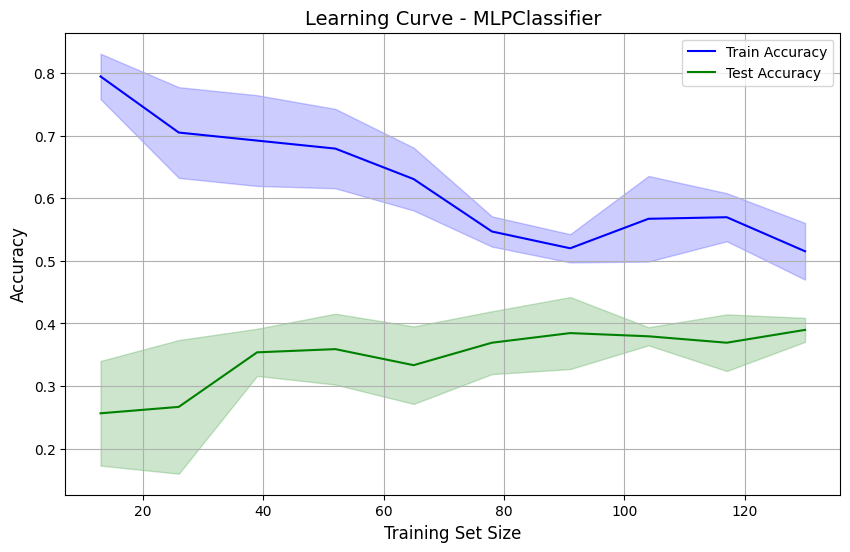

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Menggunakan model terbaik dari RandomizedSearchCV
best_mlp_random = random_search.best_estimator_

# Mendapatkan learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp_random, X_train, y_train, 
    cv=3, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Menghitung rata-rata dan standar deviasi untuk score train dan test
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', label='Train Accuracy')
plt.plot(train_sizes, test_mean, color='green', label='Test Accuracy')

# Tambahkan shading untuk menunjukkan standar deviasi
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

# Menambahkan label dan judul
plt.title('Learning Curve - MLPClassifier', fontsize=14)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()
